# From EDA to the top
https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367

## Introduction
이번 대회에서는 뉴욕 택시 여행의 총 주행 시간을 예측하는 모델을 구축해야 합니다. 꽤 많은 EDA 커널과 그 중 일부는 훌륭합니다. 여기서는 피처 추출에 더 초점을 맞추려고 합니다. 이 커널에서는 몇 가지 일반적인 캐글 관련 팁과 몇 가지 모델링 개선 아이디어도 찾을 수 있습니다.

주요 목표는 주어진 커널 제한으로 XGB에 대해 가능한 최상의 피처 세트를 만드는 것입니다.

현재 최고의 제출은 여전히 이 스크립트를 기반으로 합니다. 이러한 피처를 갖춘 최고의 단일 모델은 LB 0.371에 도달했습니다. 여러 모델의 선형 조합은 LB 0.368을 제공했습니다. 스태킹에는 0.367의 한계 개선이 추가됐습니다.

이 노트북에서는 아래와 같은 내용을 다룹니다.
- 데이터셋 탐색
- 59개의 유용한 피처 추출
- 80-20의 훈련 / 검증 셋 분할
- XGBregressor 훈련
- 피처 중요도 분석
- 테스트 셋 점수와 제출
- XGB 파라미터 체크를 통해 향상성 탐색

In [12]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

## Data Understanding

In [13]:
np.random.seed(1987)
N = 100000 # 플롯의 샘플 행 수 
t0 = dt.datetime.now()
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
sample_submission = pd.read_csv('./input/sample_submission.csv')

데이터 파일을 확인해 보겠습니다. 데이터 설명은 다음과 같습니다.
- id: 각 트립에 대한 고유 식별자
- vendor_id: 트립 레코드와 연결된 제공자를 나타내는 코드
- pickup_datetime: 미터기가 작동된 날짜 및 시간
- dropoff_datetime: 미터기가 해제된 날짜 및 시간
- passenger_count: 차량 내 승객 수(운전자 포함)
- pickup_longitude: 미터기가 체결된 경도
- pickup_latitude: 미터기가 체결된 위도
- dropoff_longitude: 미터기가 해제된 경도
- dropoff_latitude: 미터기가 해제된 위도
- store_and_fwd_flag: 차량이 서버에 연결되지 않아 벤더에 전송하기 전에 트립 레코드가 차량 메모리에 저장되었는지 여부를 나타냄(Y=저장, N=저장안함)
- trip_duration: 여행 기간(초)

dropoff_datetime과 trip_duration은 훈련 셋에서만 이용 가능합니다.

In [14]:
print("{}개의 훈련 행과 {}개의 테스트 행 가짐".format(train.shape[0], test.shape[0]))
print("{}개의 훈련 열과 {}개의 테스트 열 가짐".format(train.shape[1], test.shape[1]))
train.head(2)

1458644개의 훈련 행과 625134개의 테스트 행 가짐
11개의 훈련 열과 9개의 테스트 열 가짐


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [15]:
print('Id is unique') if train.id.nunique() == train.shape[0] else print('oops')
print('Train and test set 교집합 없음') if len(np.intersect1d(train.id.values, test.id.values)) == 0 else print('oops')
print('결측치 없음') if train.count().min() == train.shape[0] and test.count().min() == test.shape[0] else print('oops')
print('store_and_fwd_flag는 오직 두 값만 가짐 {}'.format(str(set(train.store_and_fwd_flag.unique()) | set(test.store_and_fwd_flag.unique()))))

Id is unique
Train and test set 교집합 없음
결측치 없음
store_and_fwd_flag는 오직 두 값만 가짐 {'Y', 'N'}


In [16]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values - train['trip_duration'].values) > 1]
print('Trip_duration 과 datetimes 완료') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('oops')

Trip_duration 과 datetimes 완료


In [17]:
train['trip_duration'].max() // 3600

979

최대 trip_duration 시간은 약 1000시간 까지입니다. 다행히 평가 메트릭은 RMSLE이며 RMSE는 아닙니다. 이상치는 문제를 덜 일으킬 것입니다. 우리는 우리의 타겟 레이블을 변환하고 훈련중에 RMSE를 사용할 수 있습니다.

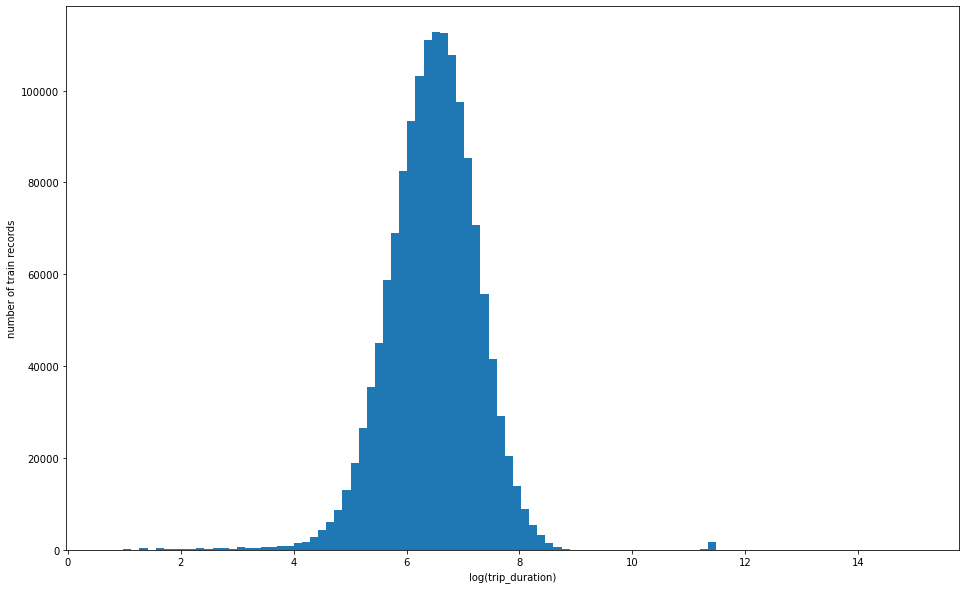

In [18]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

## Validation Strategy
먼저 train test split을 확인해보겠습니다. 검증 전략을 결정하고 피처 엔지니어링에 대한 아이디어를 제공합니다.

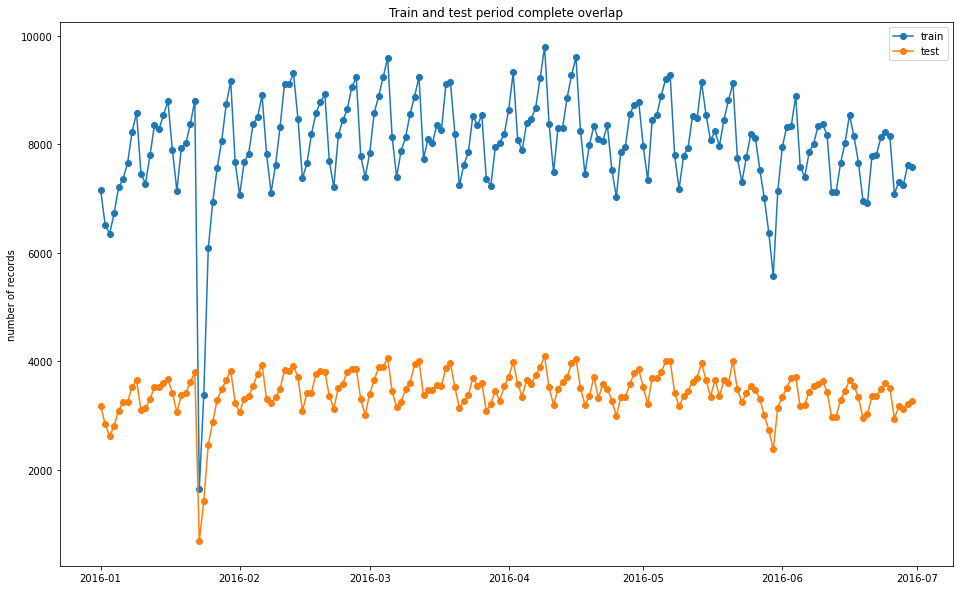

In [19]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test period complete overlap')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

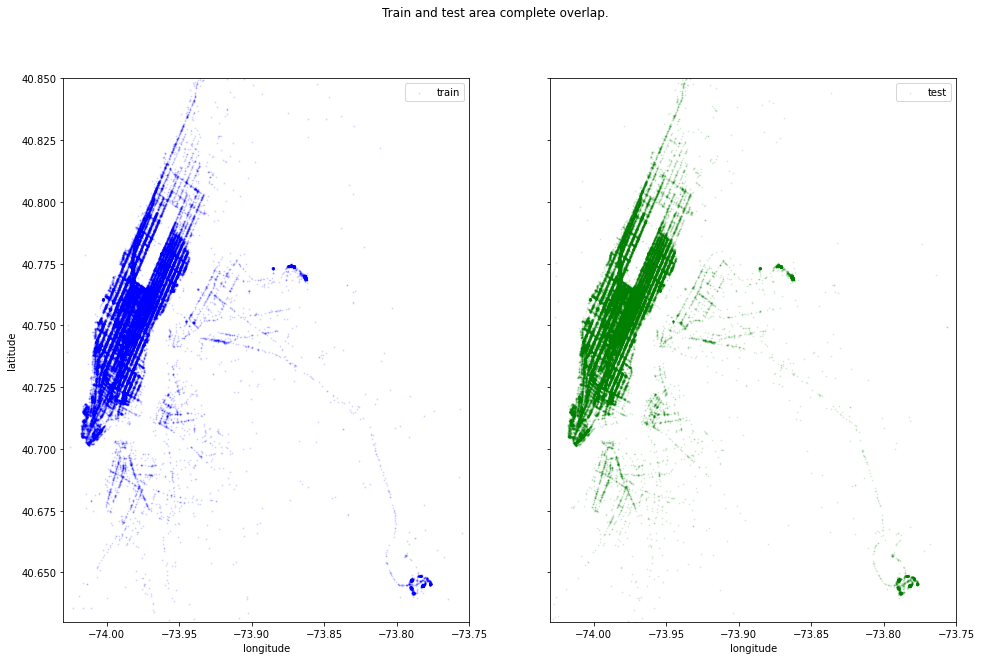

In [23]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:N], test['pickup_latitude'].values[:N],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

이 경우 훈련과 테스트 분할은 랜덤으로 보입니다. 이를 통해 전체 데이터 세트에 적용할 비지도 학습 및 피처 추출을 사용할 수 있습니다.

## Feature Extraction

### PCA
PCA를 사용하여 경도와 위도 좌표를 변환합니다. 이 경우 2D -> 2D로 변환하기 때문에 차원 축소에 관한 것이 아닙니다. 회전을 통해 의사 결정 트리 분할에 도움을 줄 수 있습니다.

In [24]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values,))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

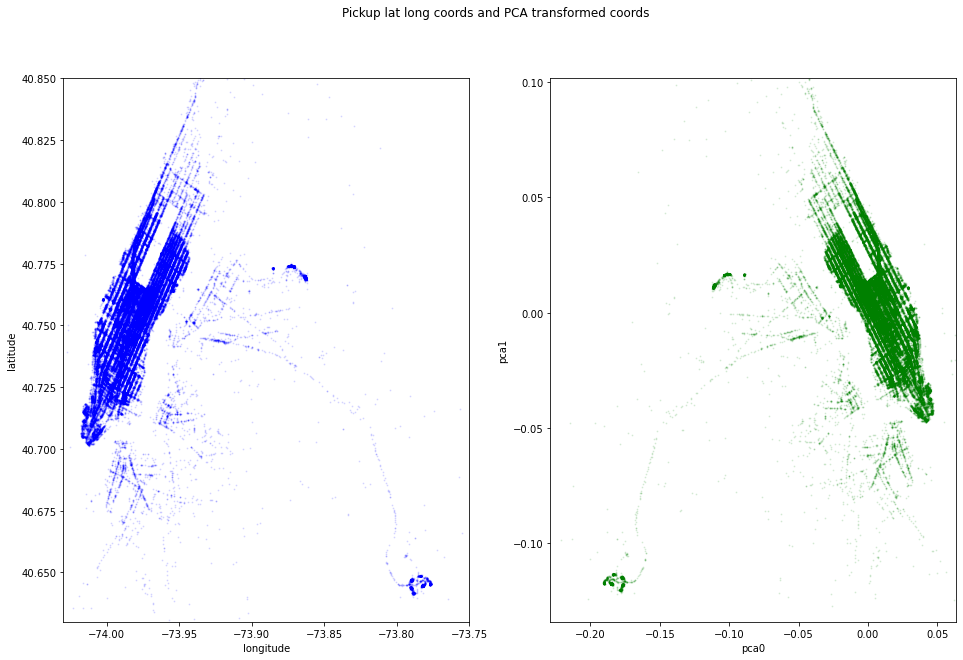

In [25]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N],
              color='green', s=1, alpha=0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

### Distance
픽업 지점과 드롭오프 지점 사이의 거리(km)를 계산해보겠습니다. 현재 Haversine이 사용되고 있는 지오피에는 원하는 경우 다른 휴리스틱(vincenty() 또는 great_circle())이 있습니다. 택시는 운행되지 않고 뉴욕이기 때문에 맨해튼(L1) 거리도 확인할 수 있습니다. 

pd.DataFrame.apply()가 너무 느려서 harvesine 기능이 다시 쓰여 어레이를 처리할 수 없습니다. 또한 경로의 중간을 피처로 추가합니다.

In [27]:
def harversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 # km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = harversine_array(lat1, lng1, lat1, lng2)
    b = harversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371 
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train.loc[:, 'distance_haversine'] = harversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

test.loc[:, 'distance_haversine'] = harversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

### Datetime features

In [28]:
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - test['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + train['pickup_hour']

### Speed

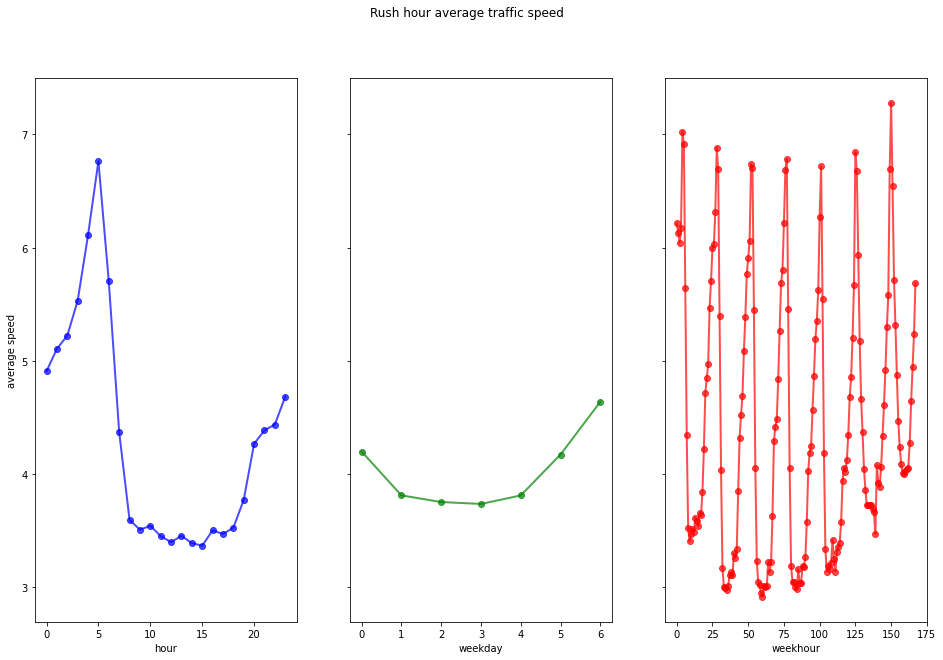

In [29]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()